# Staffing Optimization — Results Visualization

This notebook runs the staffing optimization model and visualizes the results.

**What it does:**
1. Loads data and builds the Gurobi model (via `staffing_model.py`)
2. Solves the baseline optimization
3. Visualizes inputs (demand, cost penalties)
4. Visualizes outputs (allocations, Gantt chart, shortage, idle time)

**Prerequisites:**
- `config/secrets.env` with `GUROBI_LICENSE_FILE=config/WLS-dev-key.lic`
- Python packages: `gurobipy`, `matplotlib`, `seaborn`, `numpy`

---
## 1. Setup

In [1]:
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from gurobipy import GRB

# Find project root
def find_project_root():
    for start in [Path.cwd()] + list(Path.cwd().parents):
        if (start / "agentic_explain").is_dir() and (start / "data").is_dir():
            return start
    return Path.cwd()

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Load Gurobi license
from config.load_secrets import load_secrets, get_gurobi_env_kwargs
load_secrets()

# Plotting defaults
%matplotlib inline
plt.rcParams.update({"figure.dpi": 120, "font.size": 9})

print("Project root:", PROJECT_ROOT)

Project root: /Users/Larry.Jin/Documents/research/agent_explain


---
## 2. MIP Formulation Reference

Kept here for quick reference when interpreting results.

### Data Fields

| Symbol | Description |
|--------|-------------|
| $C^{\text{miss}} \in \mathbb{R}^{D \times T}$ | Missing project demand penalty |
| $F \in \mathbb{R}^{J}$ | Employee FTE mapping |
| $P \in \mathbb{R}^{J}$ | Max concurrent projects per employee |
| $d^{p} \in \mathbb{R}^{J \times D}$ | Specific employee allocation requirement |
| $C^{p,\text{cohort}} \in \mathbb{R}^{J \times D}$ | Out-of-cohort penalty |
| $d^{p,\text{oversight}} \in \mathbb{R}^{D}$ | Oversight FTE requirement |
| $j \in J$ | Employee index |
| $d \in D$ | Project index |
| $t \in T$ | Week index |

### Variables

| Variable | Type | Description |
|----------|------|-------------|
| $x \in \mathbb{R}^{J \times T \times D}$ | Continuous $[0,1]$ | Fraction of employee $j$'s time on project $d$ in week $t$ |
| $x^{\text{ind}} \in \{0,1\}^{J \times T \times D}$ | Binary | 1 if employee $j$ has any allocation to project $d$ in week $t$ |
| $x^{p,\text{ind}} \in \{0,1\}^{J \times D}$ | Binary | 1 if employee $j$ ever works on project $d$ |
| $d^{\text{miss}} \in \mathbb{R}^{T \times D}$ | Continuous $\geq 0$ | Unmet demand for project $d$ in week $t$ |
| $x^{\text{idle}} \in \mathbb{R}^{J \times T}$ | Continuous $[0,1]$ | Idle fraction of employee $j$ in week $t$ |

### Objectives

Minimize the sum of four objectives:

$$\min \quad \underbrace{\sum_{t} \sum_{d} C^{\text{miss}}_{d,t} \cdot d^{\text{miss}}_{t,d}}_{\text{Obj 1: missing demand cost}} + \underbrace{\sum_{j} \sum_{t} x^{\text{idle}}_{j,t}}_{\text{Obj 2: idle time}} + \underbrace{\sum_{j} \sum_{d} x^{p,\text{ind}}_{j,d}}_{\text{Obj 3: staffing consistency}} + \underbrace{\sum_{j} \sum_{d} x^{p,\text{ind}}_{j,d} \cdot C^{p,\text{cohort}}_{j,d}}_{\text{Obj 4: out-of-cohort penalty}}$$

### Constraints

**Demand balance:**
$$\sum_{j} x_{j,t,d} \cdot F_{j} + d^{\text{miss}}_{t,d} = D_{d,t}, \quad \forall\, t, d$$

**Employee allocation:**
$$\sum_{d} x_{j,t,d} + x^{\text{idle}}_{j,t} = 1, \quad \forall\, j, t$$

**Indicator tracking:**
$$x^{\text{ind}}_{j,t,d} \geq x_{j,t,d}, \quad x^{\text{ind}}_{j,t,d} \leq \mathcal{M} \cdot x_{j,t,d}, \quad \forall\, j, t, d$$

**Project staffing indicator:**
$$\mathcal{M} \cdot x^{p,\text{ind}}_{j,d} \geq \sum_{t} x_{j,t,d}, \quad x^{p,\text{ind}}_{j,d} \leq \sum_{t} x_{j,t,d}, \quad \forall\, j, d$$

**Max concurrent projects:**
$$\sum_{d} x^{\text{ind}}_{j,t,d} \leq P_{j}, \quad \forall\, j, t$$

**Specific employee staffing:**
$$\sum_{t} x_{j,t,d} \geq d^{p}_{j,d}, \quad \forall\, j, d$$

**Oversight employee:**
$$\sum_{j \in \text{Oversight}} \sum_{t} x_{j,t,d} \geq d^{p,\text{oversight}}_{d}, \quad \forall\, d$$

---
## 3. Load Data & Build Model

In [2]:
from use_case.staffing_model import load_raw_data, process_data, build_gurobi_model

raw = load_raw_data(DATA_DIR)
inputs = process_data(
    raw["fte_mapping"],
    raw["concurrent_projects"],
    raw["oversight_ds_list"],
    raw["ds_list"],
    raw["project_list"],
)

ds_list = raw["ds_list"]
project_list = raw["project_list"]

print(f"Employees: {inputs['n_employees']}  |  Projects: {inputs['n_projects']}  |  Horizon: {inputs['horizon']} weeks")

Employees: 14  |  Projects: 22  |  Horizon: 26 weeks


In [13]:
for idx, proj in enumerate(raw['project_list']):
    print(f"{idx}: {proj['name']}")

0: PSO Base development
1: PSO v8 migration
2: PSO product demo
3: Paa PSO COE
4: Cgg PSO COE
5: Foo PSO Pilot
6: Nuu PSO COE
7: Saa PSO Pilot
8: IO Base development
9: IO product demo
10: Ipp IO Pilot
11: Moo IO Pilot
12: Cmm IO Pilot
13: Bhh IO COE
14: DF Base development
15: DF product demo
16: Nuu DF Pilot
17: Cmm DF Pilot
18: Hee DF COE
19: Koo DF Pilot
20: Tyy DF COE
21: Saa DF Pilot


---
## 4. Solve Baseline

In [3]:
env_kwargs = get_gurobi_env_kwargs()
model = build_gurobi_model(inputs, env_kwargs)
model.setParam(GRB.Param.TimeLimit, 100)
model.optimize()

if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT):
    decision_variables = {v.VarName: v.X for v in model.getVars()}
    print(f"\nObjective value: {model.ObjVal:.4f}")
    print(f"Status: {'OPTIMAL' if model.status == GRB.OPTIMAL else 'TIME_LIMIT'}")
else:
    raise RuntimeError(f"Model status: {model.status} — not optimal.")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2678051
WLS license 2678051 - registered to C3.ai
Set parameter TimeLimit to value 100
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (mac64[arm] - Darwin 25.2.0 25C56)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  100

WLS license 2678051 - registered to C3.ai
Optimize a model with 18262 rows, 17260 columns and 83920 nonzeros (Min)
Model fingerprint: 0xdf48fabe
Model has 1244 linear objective coefficients
Variable types: 8944 continuous, 8316 integer (8316 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [6e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 6e+00]

Found heuristic solution: objective 781.6618000
Presolve removed 6418 rows and 6062 columns
Presolve time: 0.04s
Presolved: 11844 rows, 11198 columns, 47228 nonzeros
Variable types: 5796 con

---
## 5. Parse Results

In [4]:
from agentic_explain.visualization.plots import (
    parse_decision_variables,
    print_objective_summary,
    plot_demand,
    plot_understaffing_cost,
    plot_employee_allocations,
    plot_gantt_chart,
    plot_staffing_shortage,
    plot_staffing_idle,
)

result = parse_decision_variables(decision_variables)

print("Parsed variable arrays:")
for name, arr in result.items():
    print(f"  {name:10s}  shape={arr.shape}")

Parsed variable arrays:
  x           shape=(14, 26, 22)
  x_ind       shape=(14, 26, 22)
  x_p_ind     shape=(14, 22)
  d_miss      shape=(26, 22)
  x_idle      shape=(14, 26)


### Objective Breakdown

In [5]:
obj = print_objective_summary(result, inputs)

  Missing demand cost :    56.0750
  Idle time           :    28.7333
  Staffing consistency:    43.0000
  Out-of-cohort pen.  :     2.0000
  ─────────────────────────────────
  Total               :   129.8083


---
## 6. Input Visualization

### Project Demand

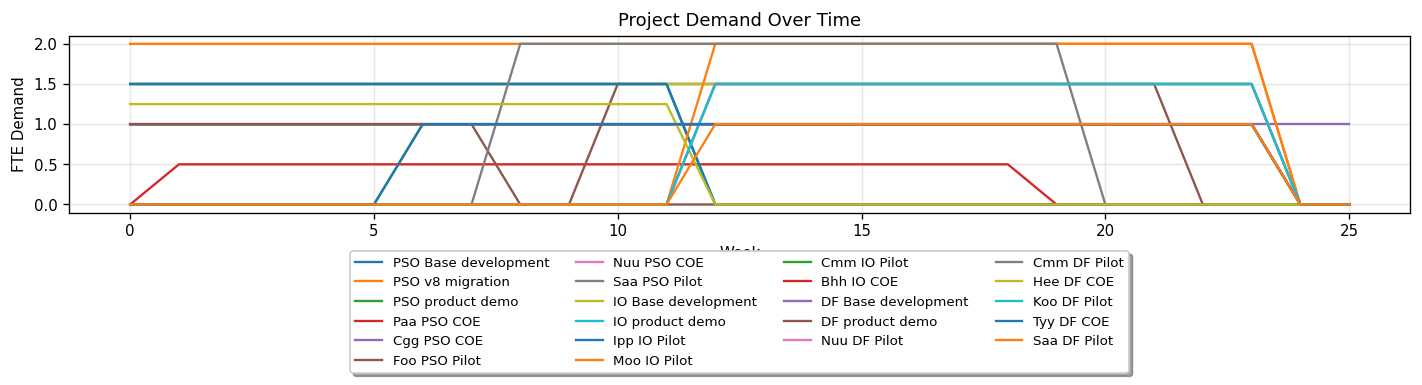

In [6]:
plot_demand(inputs["demand"], project_list);

### Understaffing Cost Penalty

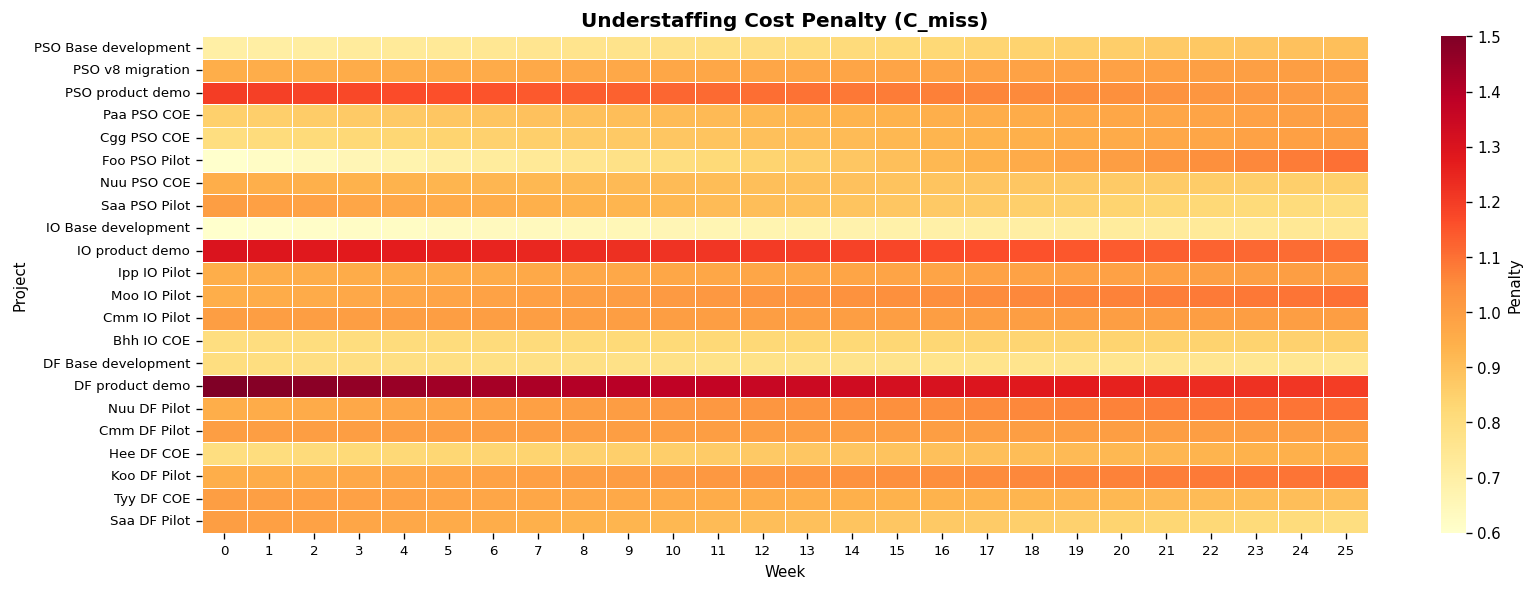

In [7]:
plot_understaffing_cost(inputs["C_miss"], project_list);

---
## 7. Result Visualization

### 7.1 Staffing Allocation — Stacked Bar (per employee)

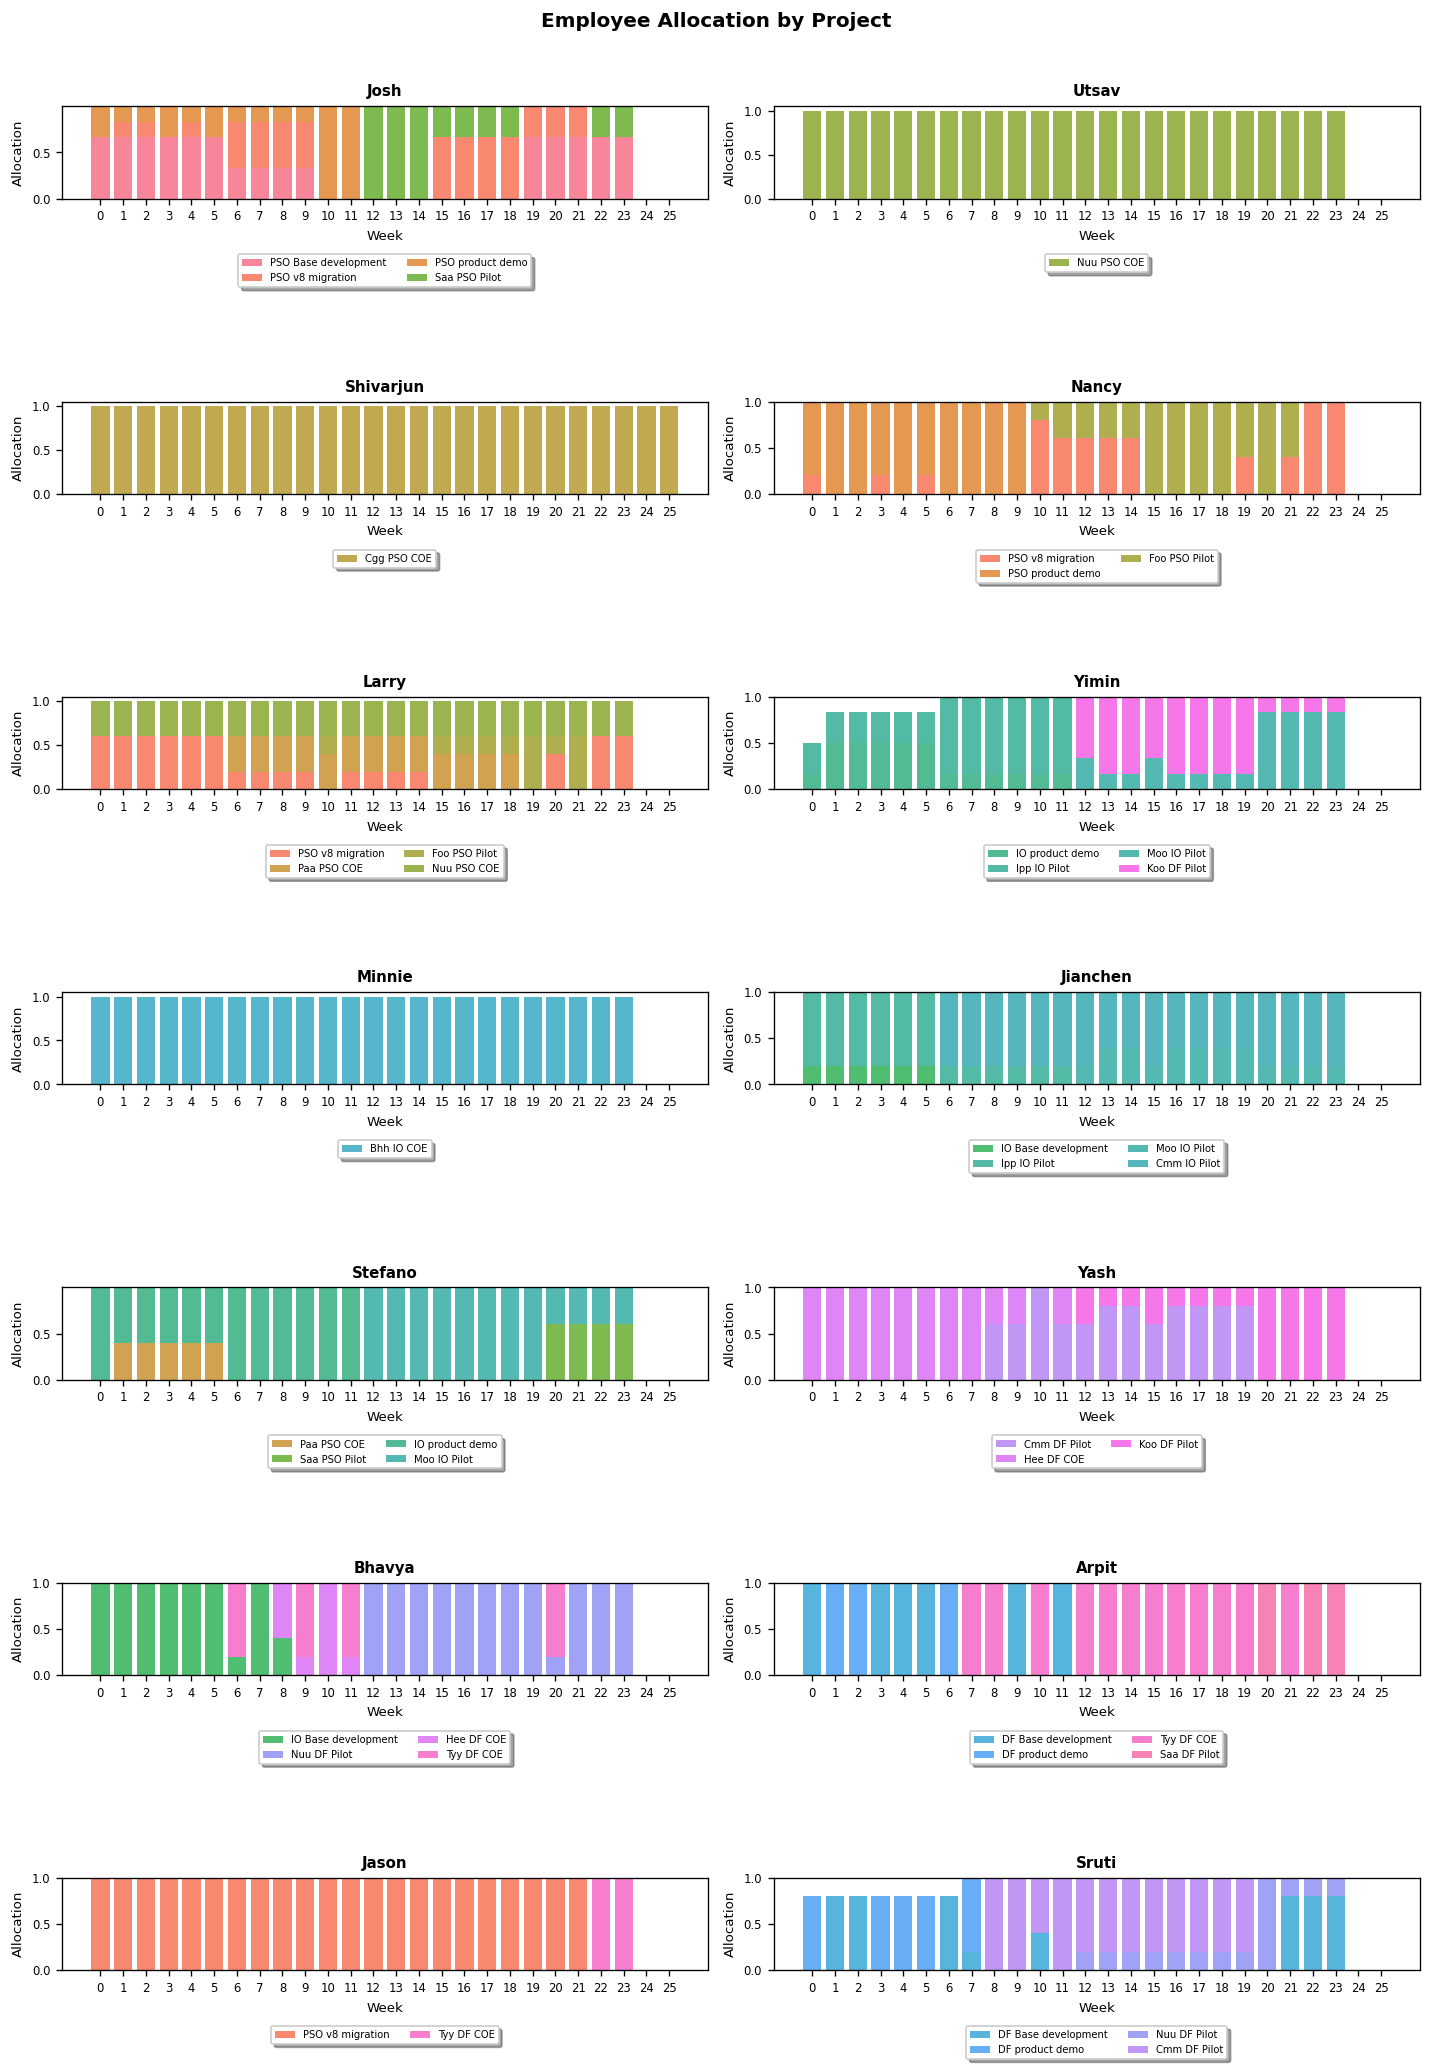

In [8]:
plot_employee_allocations(result["x"], ds_list, project_list);

### 7.2 Staffing Allocation — Gantt Chart

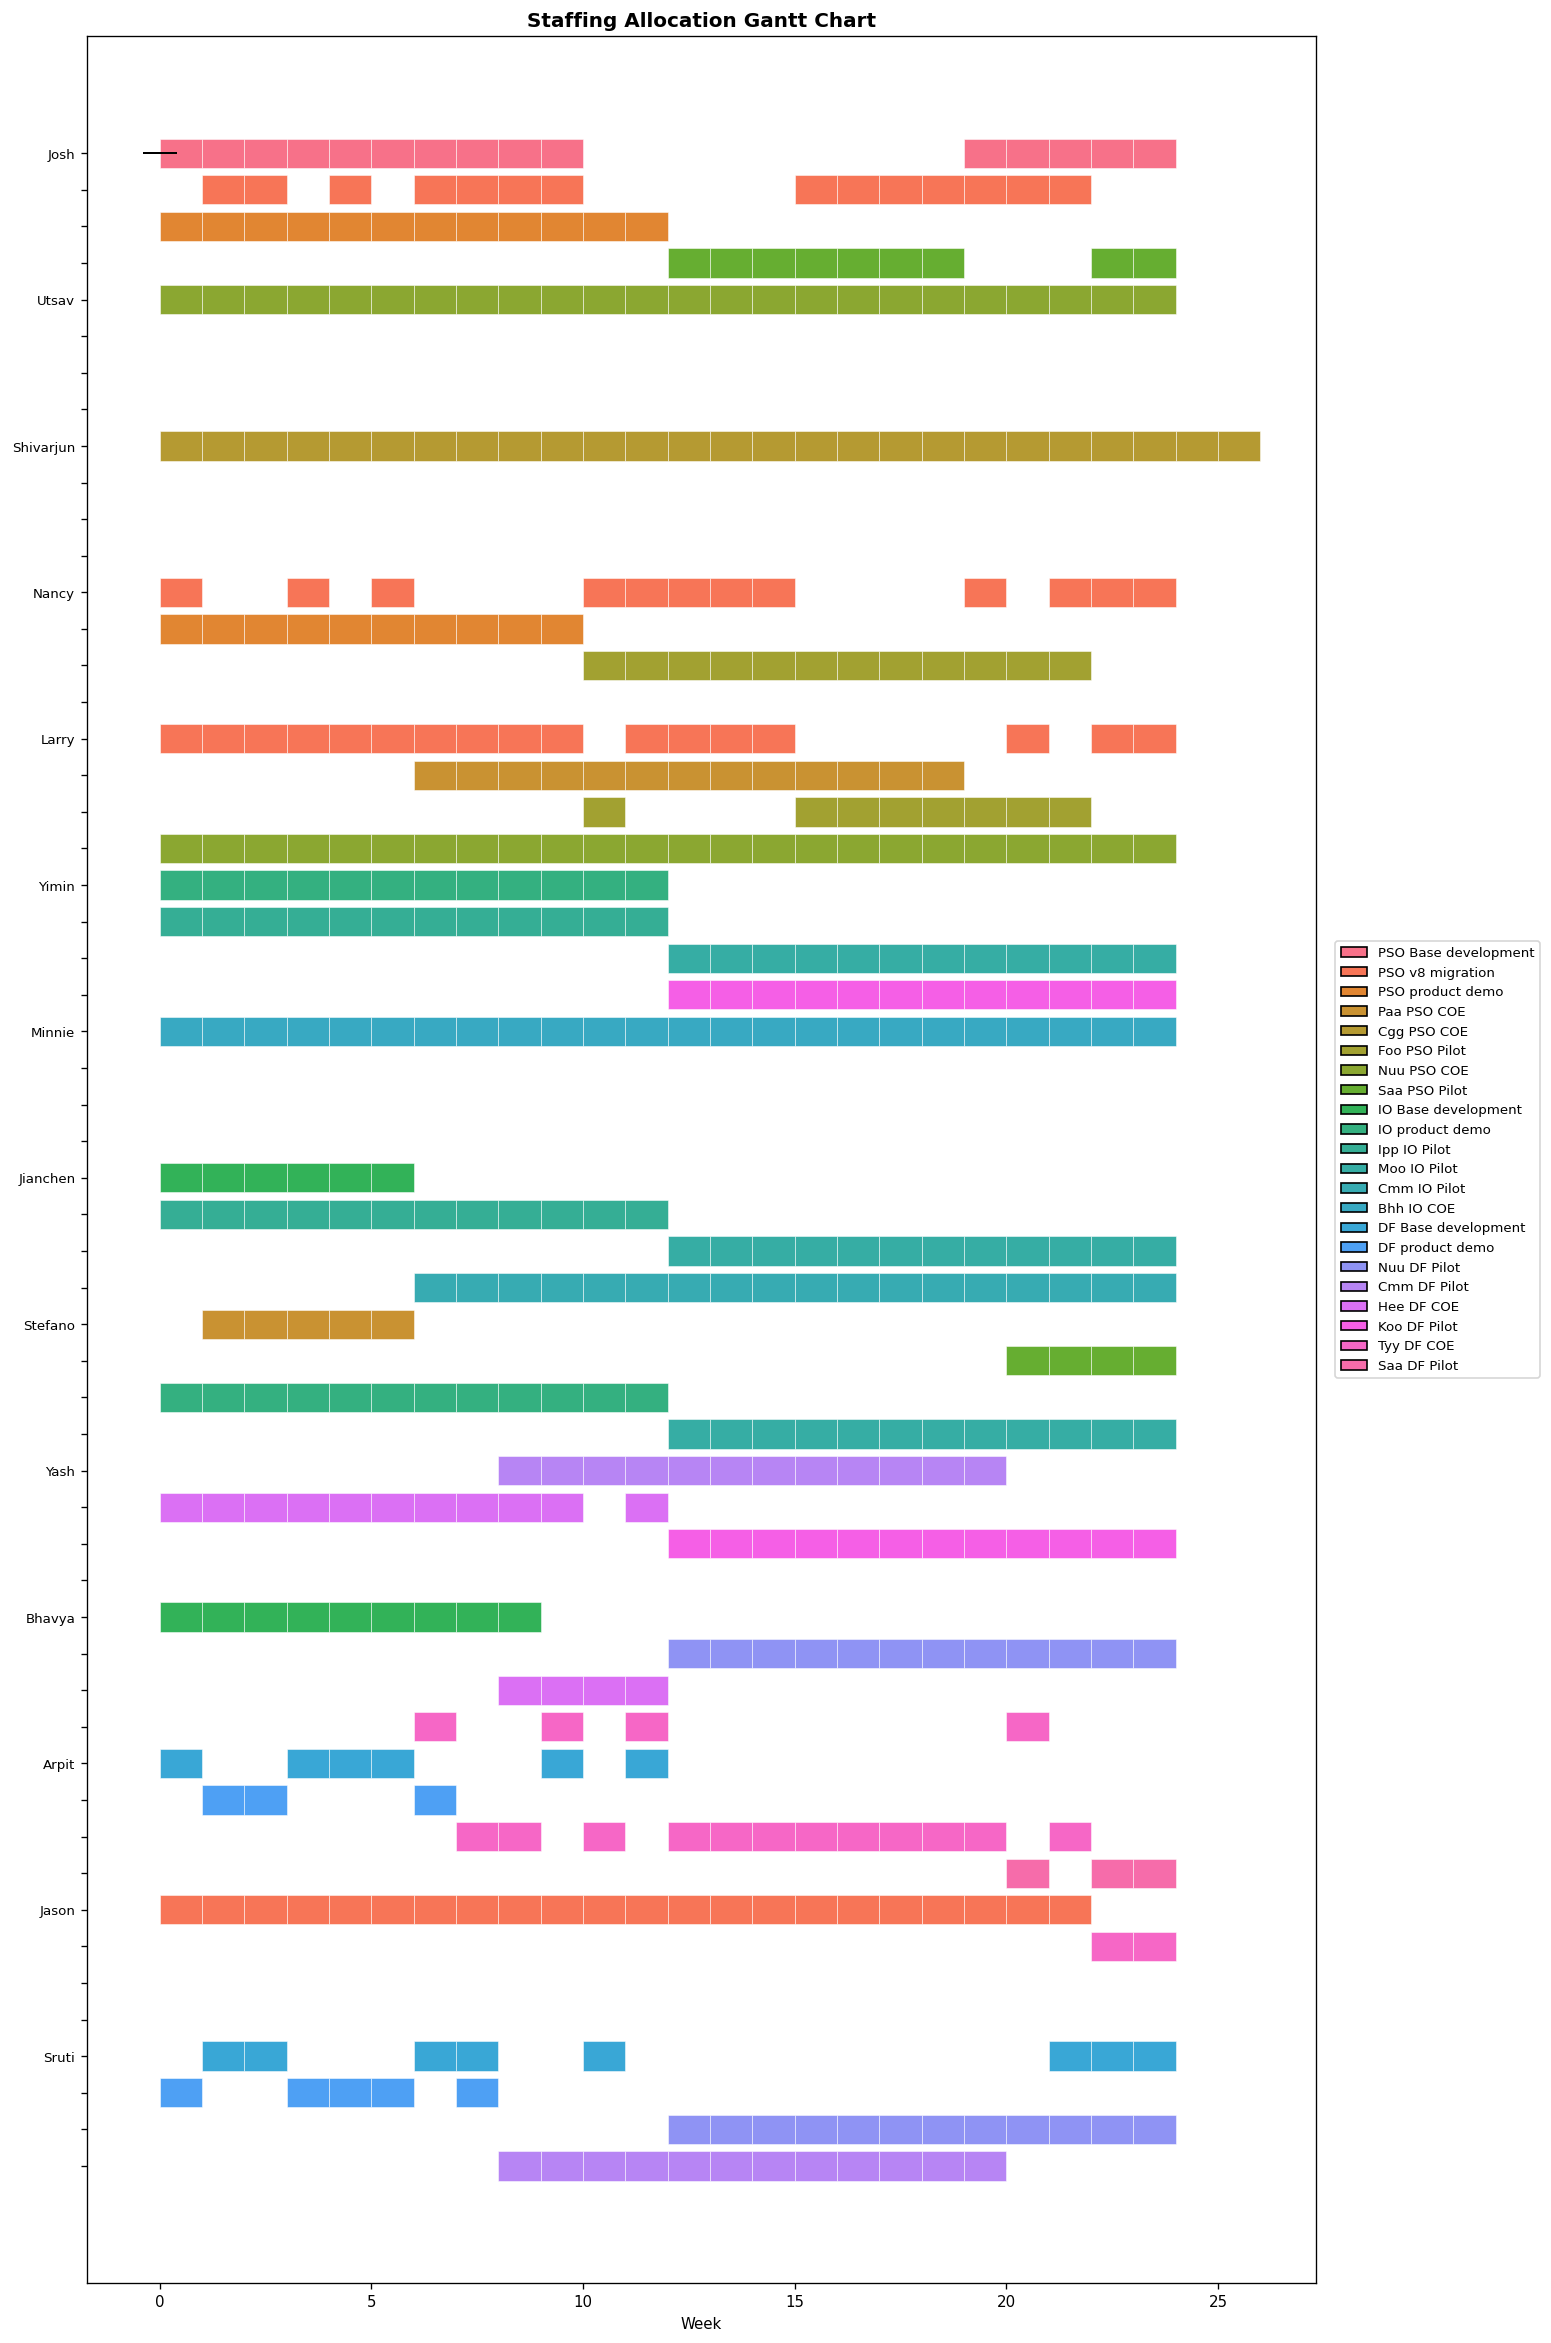

In [9]:
plot_gantt_chart(result["x"], ds_list, project_list);

### 7.3 Staffing Shortage (Unmet Demand)


Average weekly shortage: 2.7596 FTE
Average weekly demand:   18.1538 FTE


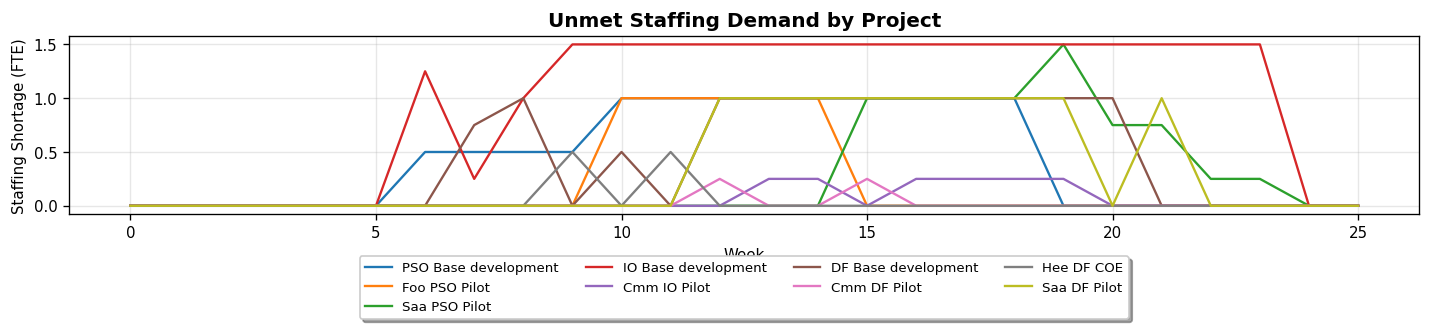

In [10]:
plot_staffing_shortage(result["d_miss"], project_list);

print(f"\nAverage weekly shortage: {result['d_miss'].sum() / inputs['horizon']:.4f} FTE")
print(f"Average weekly demand:   {inputs['demand'].sum() / inputs['horizon']:.4f} FTE")

### 7.4 Employee Idle Time


Average weekly idle: 1.1051 FTE


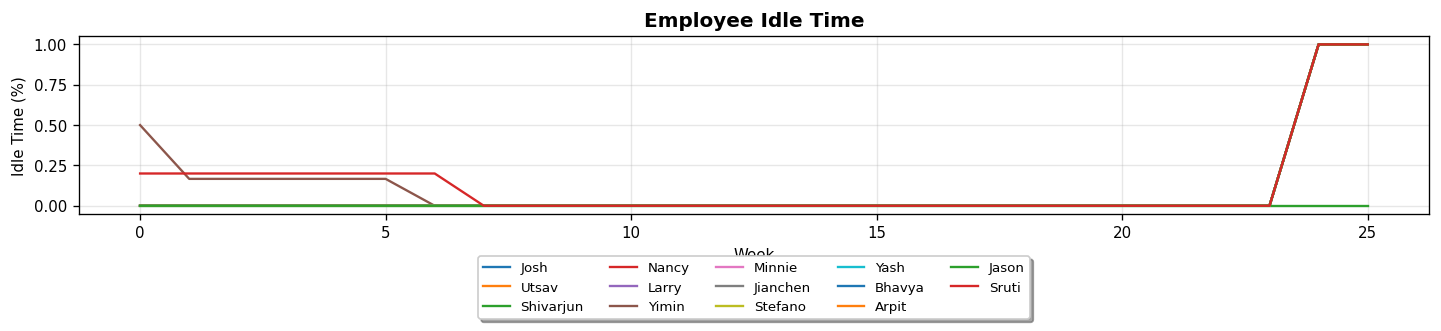

In [11]:
plot_staffing_idle(result["x_idle"], ds_list);

print(f"\nAverage weekly idle: {result['x_idle'].sum() / inputs['horizon']:.4f} FTE")